In [29]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
extracted_coefficients_directory_Bzeta = '../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/Bzeta/'
extracted_coefficients_directory_beta = '../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/beta/'

In [4]:
def find_closest_element(y: float, arr: np.ndarray):
    index = np.searchsorted(arr,y)
    if index >= 1 and index < len(arr):
        res = [arr[index - 1], arr[index]]
    elif index == len(arr) :
        return np.array(index - 1)
    else:
        return index

    if res[0] == res[1]:
        return np.array(index - 1)
    else:
        diff_pre = np.abs(y-res[0])
        diff_aft = np.abs(y-res[1])
        if diff_pre == diff_aft:
            return np.array(index - 1)
        else:
            return index - 1 if diff_pre < diff_aft else index

In [5]:
density_path = '../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)

In [6]:
labels = np.load(str(extracted_coefficients_directory_Bzeta + 'labels_val.npy'))
B_zetas = np.load(str(extracted_coefficients_directory_Bzeta + 'B_zeta_val.npy'))
tr_labels = np.load(str(extracted_coefficients_directory_Bzeta + 'tr_labels_val.npy'))

In [24]:
#beta_dnn = np.genfromtxt('../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/beta/beta.csv', delimiter = ',')
beta_mcmc = np.mean(np.genfromtxt('../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/betas.csv', delimiter = ',')[10000:,:], axis = 0)
beta_va = np.mean(np.genfromtxt('../../data/commaai/va/filtered_gaussian_resampled/Ridge/mu_t_va.csv', delimiter = ',')[20000:,0:10], axis = 0)
beta_va_horse = np.mean(np.load('../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/mu_ts_delete.npy')[20000:,0:10], axis = 0).reshape(10,)
beta_dnn = np.genfromtxt(str(extracted_coefficients_directory_beta + 'beta.csv'), delimiter = ',')
beta_dnn_0 = np.genfromtxt(str(extracted_coefficients_directory_beta + 'beta0.csv'), delimiter = ',')

In [25]:
# transformed
pred_mcmc = pd.DataFrame({'pred_z':  [item for sublist in B_zetas.dot(beta_mcmc) for item in sublist]})
pred_va = pd.DataFrame({'pred_z': [item for sublist in  B_zetas.dot(beta_va)for item in sublist]})
pred_dnn = pd.DataFrame({'pred_z': [item for sublist in (B_zetas.dot(beta_dnn) + beta_dnn_0) for item in sublist]})
pred_va_horse = pd.DataFrame({'pred_z': [item for sublist in B_zetas.dot(beta_va_horse) for item in sublist]})
mae__z_mcmc = np.mean(abs(pred_mcmc['pred_z'] - tr_labels))
mae_z_va = np.mean(abs(pred_va['pred_z'] - tr_labels))
mse_z_mcmc = np.mean(abs(pred_mcmc['pred_z'] - tr_labels)**2)
mse_z_va = np.mean(abs(pred_va['pred_z'] - tr_labels)**2)
# transformed back

In [45]:
tqdm.pandas()
pred_mcmc['pred_y'] = pred_mcmc['pred_z'].progress_apply(lambda x: density.loc[find_closest_element(norm.cdf(x), density['cdf']), 'axes'])
pred_va['pred_y'] = pred_va['pred_z'].progress_apply(lambda x: density.loc[find_closest_element(norm.cdf(x), density['cdf']), 'axes'])
pred_dnn['pred_y'] = pred_dnn['pred_z'].progress_apply(lambda x: density.loc[find_closest_element(norm.cdf(x), density['cdf']), 'axes'])
pred_va_horse['pred_y'] = pred_va_horse['pred_z'].progress_apply(lambda x: density.loc[find_closest_element(norm.cdf(x), density['cdf']), 'axes'])


100%|██████████| 10472/10472 [00:06<00:00, 1545.86it/s]


In [52]:
mae_y_mcmc = np.mean(abs(pred_mcmc['pred_y'] - labels))
mae_y_va = np.mean(abs(pred_va['pred_y'] - labels))
mae_y_dnn = np.mean(abs(pred_dnn['pred_y'] - labels))
mae_y_va_horse = np.mean(abs(pred_va_horse['pred_y'] - labels))

accuracy_mcmc = np.mean(abs(pred_mcmc['pred_y'] - labels) <= 6)
accuracy_va = np.mean(abs(pred_va['pred_y'] - labels) <= 6)
accuracy_dnn = np.mean(abs(pred_dnn['pred_y'] - labels) <= 6)
accuracy_va_horse = np.mean(abs(pred_va_horse['pred_y'] - labels) <= 6)

mse_y_mcmc = np.mean(abs(pred_mcmc['pred_y'] - labels)**2)
mse_y_va = np.mean(abs(pred_va['pred_y'] - labels)**2)
mse_y_dnn = np.mean(abs(pred_dnn['pred_y'] - labels)**2)
mse_y_va_horse = np.mean(abs(pred_va_horse['pred_y'] - labels)**2)

print('mean absolute error MCMC Ridge: ' + str(mae_y_mcmc) +
     '\nmean absolute error VA Ridge: ' + str(mae_y_va) +
     '\nmean absolute error DNN: ' + str(mae_y_dnn) +
     '\nmean absolute error Horseshoe: ' + str(mae_y_va_horse) +
     '\naccuracy MCMC Ridge ' + str(accuracy_mcmc) +
     '\naccuracy VA Ridge ' + str(accuracy_va) +
      '\naccuracy DNN Ridge ' + str(accuracy_dnn) +
    '\nnaccuracy Horseshoe: ' + str(accuracy_va_horse) +
     '\nmean squared error MCMC Ridge: ' + str(mse_y_mcmc) +
     '\nmean squared error VA Ridge: ' + str(mse_y_va) +
     '\nmean squared error DNN Ridge: ' + str(mse_y_dnn) +
     '\nmean squared error Horseshoe: ' + str(mse_y_va_horse) )

mean absolute error MCMC Ridge: 1.8736253357536288
mean absolute error VA Ridge: 1.8782274197375397
mean absolute error DNN: 1.4723754631398838
mean absolute error Horseshoe: 2.563226546056439
accuracy MCMC Ridge 0.9611344537815126
accuracy VA Ridge 0.9609434682964094
accuracy DNN Ridge 0.980423987776929
naccuracy Horseshoe: 0.9197860962566845
mean squared error MCMC Ridge: 11.849518742758795
mean squared error VA Ridge: 11.94035514863639
mean squared error DNN Ridge: 7.654203032172087
mean squared error Horseshoe: 22.910075403062457


In [53]:
np.sqrt(22.910075403062457)

4.786447054242056

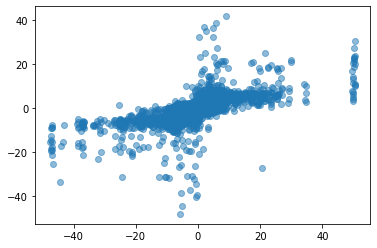

In [54]:
plt.scatter(pred_va_horse['pred_y'], labels, alpha = 0.5)

(array([6587.,  211.,  238.,  296.,  243.,  248.,  208.,  153.,  113.,
        2175.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

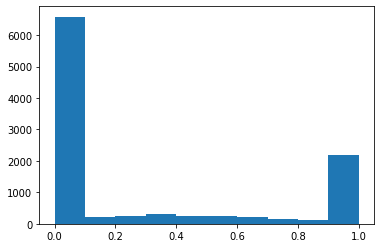

In [41]:
plt.hist(pred_mcmc['pred_y'])

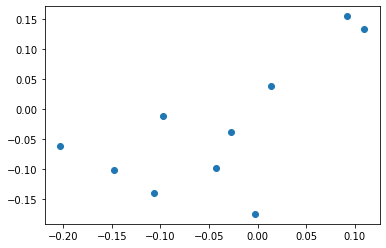

In [62]:
plt.scatter(beta_va_horse, beta_mcmc)

In [57]:
pred_va_horse.shape

(10472, 2)